<a href="https://colab.research.google.com/github/serzzh/courseraSCM/blob/master/Coursera_Supply_Chain_Planning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (24,6)

Populating the interactive namespace from numpy and matplotlib


# Prepare data

### Downloading and reading data

In [0]:
url = "https://d3c33hcgiwev3.cloudfront.net/_dc27d596205cf8e528acb844f516e28b_Supply-Chain-Planning-Assignment-Data.csv?Expires=1574467200&Signature=VPZCN3Jm~KOMcOHCAcX7dZ11zHHzTQyqqJ4mzJvnD~h-3MwljnRTJ9uTA3Xpy0j8bekZ8EQmq8JOBZjwkxOCgYTqCXaWi3scAfJe8M64nwAe8EGhv9mGLgLXC7JS5DS9vKl3MtoBzfZmemHySZvxi~SznGZiT1mHeGL4Qfc~j50_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
df = pd.read_csv(url, header='infer')
df = df[df.columns[:5]].iloc[1:].apply(lambda x: x.str.replace(',',''))
df.replace(' -   ', 0.0, inplace=True)
df.columns = ['Date', 'Sales of A', 'Sales of B', 'Sales of C', 'Sales of D']
df['Date'] = df['Date'].astype('datetime64[ns]')
df = df.set_index('Date').apply(pd.to_numeric)
df.head()

,Sales of A,Sales of B,Sales of C,Sales of D
Date,,,,
2011-01-03,210.0,702.0,18.0,516.0
2011-01-04,10294.0,402.0,0.0,324.0
2011-01-05,3395.0,438.0,0.0,3618.0
2011-01-06,432.0,19.0,0.0,414.0
2011-01-07,106.0,0.0,0.0,72.0


### Visualising data

Text(0.5, 1.0, 'Sales of D')

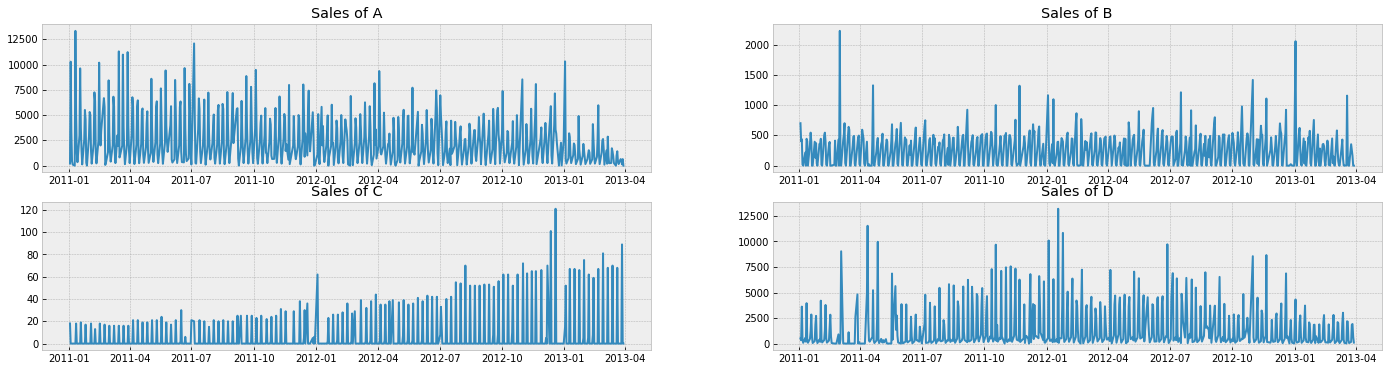

In [0]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(df['Sales of A'])
ax[0, 0].set_title('Sales of A')
ax[0, 1].plot(df['Sales of B'])
ax[0, 1].set_title('Sales of B')
ax[1, 0].plot(df['Sales of C'])
ax[1, 0].set_title('Sales of C')
ax[1, 1].plot(df['Sales of D'])
ax[1, 1].set_title('Sales of D')

Probably we should aggregate data by month too gain more insights

In [0]:
df = df.resample('M').sum()
df2 = df.copy()

Text(0.5, 1.0, 'Sales of D')

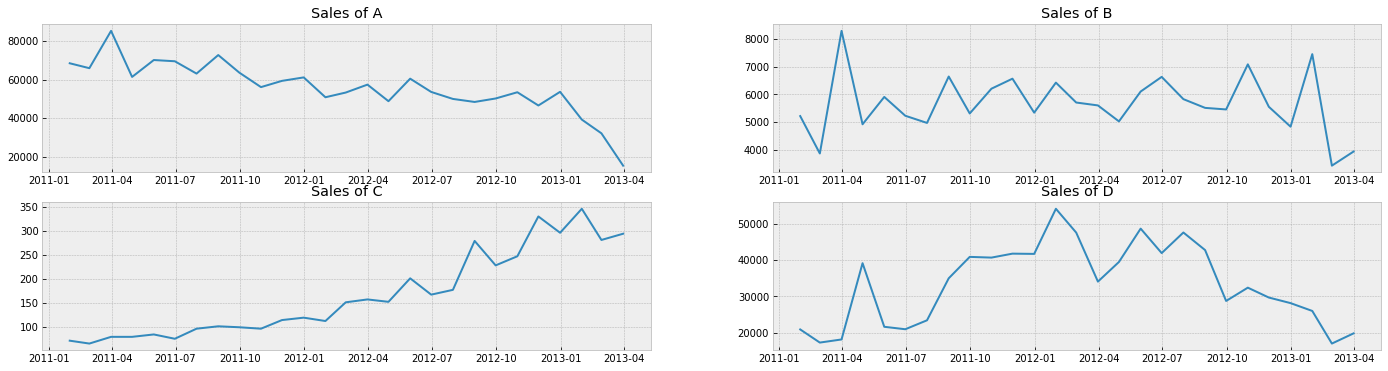

In [0]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(df['Sales of A'])
ax[0, 0].set_title('Sales of A')
ax[0, 1].plot(df['Sales of B'])
ax[0, 1].set_title('Sales of B')
ax[1, 0].plot(df['Sales of C'])
ax[1, 0].set_title('Sales of C')
ax[1, 1].plot(df['Sales of D'])
ax[1, 1].set_title('Sales of D')

# Define appropriate forecasting method

Let's try to approximate our sales timeseries with following methods:

1.   Moving average
2.   Exponential Smoothing



## Moving average

Defining function for moving average

In [0]:
def mov_av(df, n=3):
  df = df.rolling(n).mean().shift(1).round(0)[n:].astype(int)
  df.columns = ['Mov.Av. of A', 'Mov.Av. of B', 'Mov.Av. of C', 'Mov.Av. of D']
  return df

Finding optimal value for number of periods using MSE as main metriics

In [0]:
def err(x,y, metrics = 'mse'):
  result = {
      'me': lambda x, y: sum(x-y)/len(x), # Mean Error
      'mape': lambda x, y: sum(abs(x-y)/x)/len(x), # Mean Absolute Percent Error
      'mse': lambda x, y: sum((x-y)*(x-y))/len(x) # Mean Square Error
      }[metrics](x,y)

  return result

In [0]:
def find_n(df, metrics = ['me', 'mape','mse']): #N optimization function
  
  out = []
  n = range(1, 7)

  for col in df.columns:
    x = df[col]
    errors = []
    for a in n:
        y = mov_av(x, a)
        errors.append({'col': col,
                      "N":a, 
                      "me": err(x[1:-1], y[:-1], metrics='me'),
                      "mape": err(x[1:-1], y[:-1], metrics='mape'),
                      "mse": err(x[1:-1], y[:-1], metrics='mse')
                      })
        
    er1 = pd.DataFrame.from_records(errors)
    for m in metrics:
      out.append(er1.iloc[er1[m].idxmin()])

  return pd.DataFrame.from_records(out)


In [0]:
er1 = find_n(df[['Sales of A', 'Sales of B', 'Sales of C', 'Sales of D']])

In [0]:
opt = er1.iloc[er1.groupby('col')['mse'].idxmin()] # finding alpha with minimum MSE for all products
opt

,col,N,me,mape,mse
2,Sales of A,3,-3030.36,0.099006,38546864.60
4,Sales of B,5,-59.68,0.117352,734718.48
8,Sales of C,3,18.56,0.117841,1121.04
9,Sales of D,4,-343.52,0.184209,59802987.04


Calculating Moving Average with N calculated above

In [0]:
df = df.join(
    mov_av(df, opt[opt.col=='Sales of A'].N.values[0])['Mov.Av. of A'], how='inner'
    ).join(
        mov_av(df, opt[opt.col=='Sales of B'].N.values[0])['Mov.Av. of B'], how='inner'
    ).join(
        mov_av(df, opt[opt.col=='Sales of C'].N.values[0])['Mov.Av. of C'], how='inner'
    ).join(
        mov_av(df, opt[opt.col=='Sales of D'].N.values[0])['Mov.Av. of D'], how='inner'
    )

Text(0.5, 1.0, 'Sales of D, Mov.Av. of D')

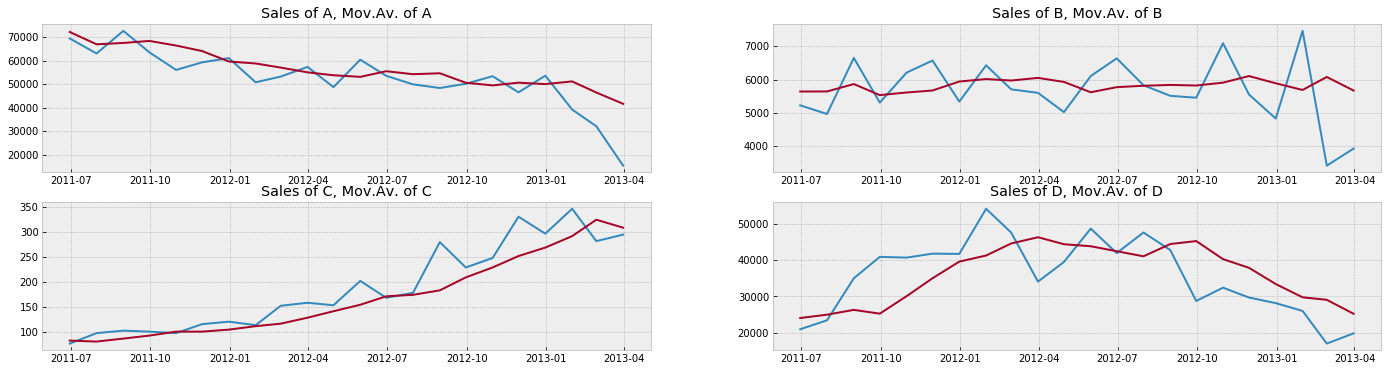

In [0]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(df[['Sales of A', 'Mov.Av. of A']])
ax[0, 0].set_title('Sales of A, Mov.Av. of A')
ax[0, 1].plot(df[['Sales of B', 'Mov.Av. of B']])
ax[0, 1].set_title('Sales of B, Mov.Av. of B')
ax[1, 0].plot(df[['Sales of C', 'Mov.Av. of C']])
ax[1, 0].set_title('Sales of C, Mov.Av. of C')
ax[1, 1].plot(df[['Sales of D', 'Mov.Av. of D']])
ax[1, 1].set_title('Sales of D, Mov.Av. of D')

We can find that moving average with optimal N parameter overall cathes trend but lack reactions on the fluctuations of demand

## Exponential Smoothing

Finding optimal alpha for smoothing

In [0]:
def round_half_up(n, decimals=0): # Excel-like rounding function
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

In [0]:
def exp_av(df, cols, alpha): # Exponential Smoothing
  ea = []
  for i in range(len(df[cols])-1):
    fc = ea[i-1] if i >0 else df[cols][0]
    ea.append(round_half_up(df[cols][i]*alpha + fc*(1-alpha)))
  return ea

In [0]:
def find_alpha(df, metrics = ['me', 'mape','mse']): #Alpha optimization functio
  
  out = []
  alpha = [k * 0.1 for k in range(0, 11)]
  
  for col in df.columns:
    x = df[col]
    errors = []
    for a in alpha:
        y = exp_av(df, col, a)
        errors.append({'col': col,
                      "alpha":a, 
                      "me": err(x[1:-1], y[:-1], metrics='me'),
                      "mape": err(x[1:-1], y[:-1], metrics='mape'),
                      "mse": err(x[1:-1], y[:-1], metrics='mse')
                      })
        
    er1 = pd.DataFrame.from_records(errors)
    for m in metrics:
      out.append(er1.iloc[er1[m].idxmin()])

  return pd.DataFrame.from_records(out)

In [0]:
er2 = find_alpha(df2[['Sales of A', 'Sales of B', 'Sales of C', 'Sales of D']])

In [0]:
er2.iloc[er2.groupby('col')['mse'].idxmin()] # finding alpha with minimum MSE for all products

,col,alpha,me,mape,mse
2,Sales of A,0.4,-2768.88,0.113479,56971264.56
4,Sales of B,0.1,173.00,0.145711,1241678.52
8,Sales of C,0.7,12.84,0.116684,1176.20
11,Sales of D,0.6,16.32,0.195464,67237450.00


We can find that the results of exponential smoothing is worse than moving average if using MSE metrics for all products except C, which results is very similar.

In [0]:
opt #Below the results of moving averave forecast which is better

,col,N,me,mape,mse
2,Sales of A,3,-3030.36,0.099006,38546864.60
4,Sales of B,5,-59.68,0.117352,734718.48
8,Sales of C,3,18.56,0.117841,1121.04
9,Sales of D,4,-343.52,0.184209,59802987.04


So on current data is better to use moving average.